In [1]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# Set Seaborn style
sns.set(style='darkgrid', font_scale=1.2)
from sklearn.datasets import make_moons

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)
#torch.manual_seed(42) # Setting the seed
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.distributions.multivariate_normal import MultivariateNormal

from torch.utils.tensorboard import SummaryWriter
import torch.profiler

from GPUtil import showUtilization as gpu_usage

Using torch 2.1.0


In [2]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, SIGMA):
        super().__init__()
        self.sigma = SIGMA
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        g_x = self.layers(x)
        return g_x + self.sigma*torch.randn_like(g_x)

class EBM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        # Returns grad_z[ f_a(z) ]
        return self.layers(x)

In [3]:
# # class PriorSampler():
# #     def __init__(self, K, s, device):
# #         self.device = device
# #         self.K = torch.tensor(K, device=self.device)
# #         self.s = torch.tensor(s, device=self.device)
    
# #     def get_sample(self, x, EBM):
# #         z_k = torch.randn_like(x, device=self.device)
# #         step=0
# #         while step < self.K:
# #             z_k = z_k + self.s * (EBM(z_k)-z_k) + (torch.sqrt(2*self.s)*torch.randn_like(z_k, device=self.device))
# #             step += 1
        
# #         return z_k

# class PosteriorSamples():
#     def __init__(self, K, s, sigma, device):
#         self.device = device
#         self.K = torch.tensor(K, device=self.device)
#         self.s = torch.tensor(s, device=self.device)
#         self.sigma = sigma
    
#     # def get_sample(self, x, z_prior, GEN):
#     #     # Sample from prior
#     #     z_k = z_prior
#     #     step=0
#     #     while step < self.K:
#     #         g_k = GEN(z_k)
            
#     #         # x = g(z) + eps
#     #         x_k = g_k + self.sigma*torch.randn_like(x, device=self.device) 
#     #         z_k = z_k + self.s * -(x_k - g_k)/(self.sigma**2) + (torch.sqrt(2*self.s)*torch.randn_like(z_k, device=self.device))
#     #         step += 1
        
#     #     return z_k
    
#     def get_sample(self, x, z_prior, GEN):
#         z_k = torch.randn_like(x, device=self.device)
#         mvn_posterior = MultivariateNormal(g_k, scale_tril=torch.diag(self.sigma*2))
#         step =0 
#         while step < self.K:
#             g_k = GEN(z_k)
#             x_k = g_k + self.sigma*torch.randn_like(x, device=self.device) 
#             x_prime = torch.randn_like(x, device=self.device)
#             log_ratio = mvn_posterior.log_prob(x_prime) - mvn_posterior.log_prob(x_k)  
#             acceptance = torch.exp(log_ratio)
            
#             u = torch.rand(1, device=self.device)
#             if u <= acceptance:
#                 x_k = x_prime            
            
#         return z_k

class langevin_sampler():
    def __init__(self, sampling_steps, initial_step_size, device):
        self.device = device
        self.K = torch.tensor(sampling_steps, device=self.device)
        self.s = torch.tensor(initial_step_size, device=self.device)
    
    def get_sample(self, initial_sample, grad_log_fcn):
        x_k = initial_sample
        step=0
        
        while step < self.K:
            # Compute gradient
            grad = grad_log_fcn.get(x_k)
            
            # Update sample
            x_k = x_k + self.s * grad + (torch.sqrt(2*self.s)*torch.randn_like(x_k, device=self.device))  
            
            step += 1             
        
        return x_k
    
    
class grad_log_posterior():
    def __init__(self, sigma, GEN, device):
        self.device = device
        self.sigma = torch.tensor(sigma, device=self.device)
        self.GEN = GEN
        self.z = None

    def get(self, x):
        return -(x-self.GEN(self.z))/(self.sigma**2) - self.z

    def update(self, z, GEN):
        self.z = z
        self.GEN = GEN
    

In [4]:
def loss_function(x, x_pred, sigma, z):
    log_prior = -0.5 * torch.square(z)
    log_likelihood = -torch.log(sigma) - (0.5 * torch.square(x - x_pred) / sigma**2)
    return torch.mean(-log_prior - log_likelihood)

  0%|          | 0/10000 [00:00<?, ?it/s]

STAGE:2023-11-07 14:29:24 2456455:2456455 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-11-07 14:29:24 2456455:2456455 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-07 14:29:24 2456455:2456455 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
/tmp/ipykernel_2456455/406666596.py:106: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


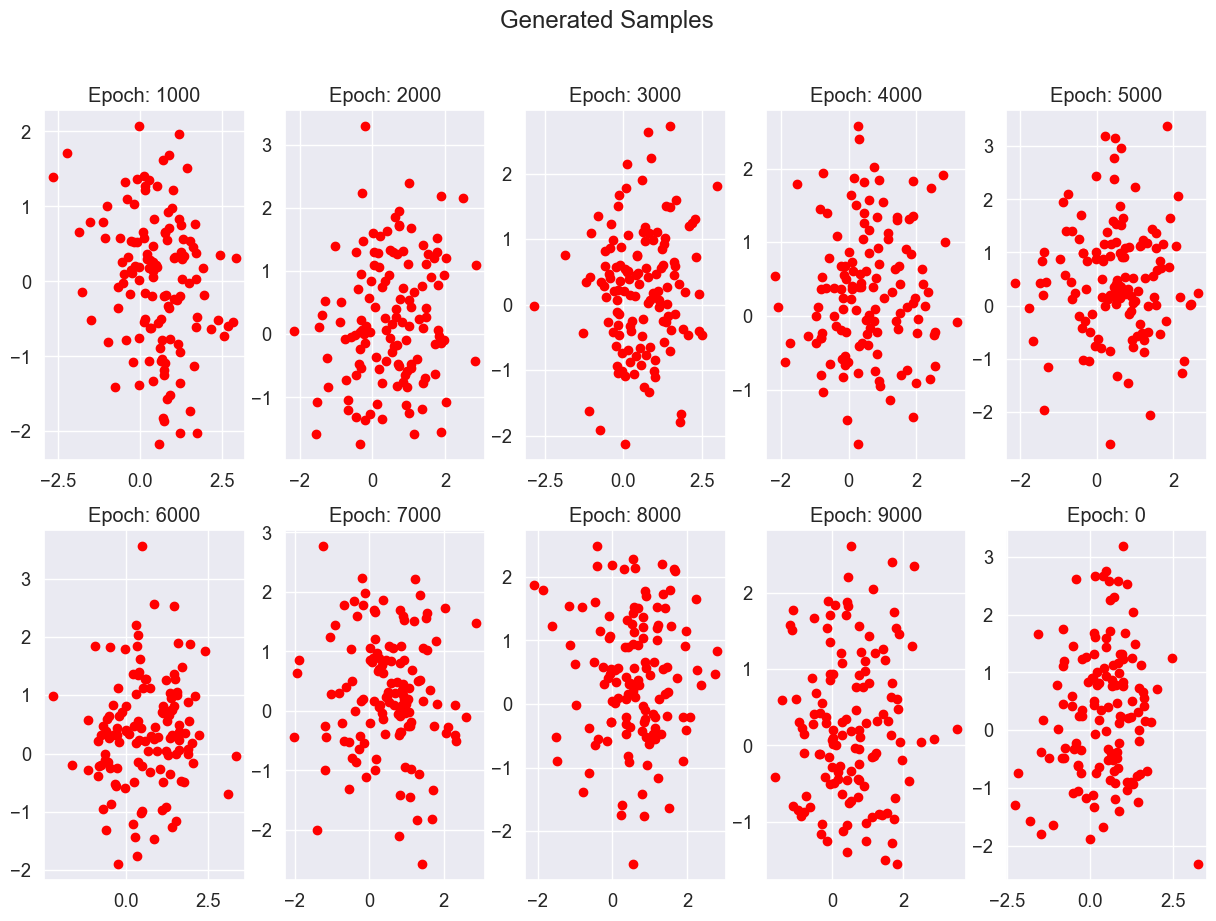

In [5]:
NUM_EPOCHS = 10000
BATCH_SIZE = 128
LR = 1e-3
K_prior = 20
K_posterior = 70
SAMPLES=2500
SIGMA=1
LANG_NOISE = 1

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the moons dataset
X, _ = make_moons(n_samples=SAMPLES, noise=0.05, random_state=42)
X = torch.tensor(X).float().to(device)

GENnet = Generator(input_dim=X.shape[1], output_dim=X.shape[1], SIGMA=SIGMA).to(device)
# EBMnet = EBM(input_dim=X.shape[1], output_dim=X.shape[1]).to(device)
# prior_smp = PriorSampler(K_prior, 0.1, device)
grad_log_post = grad_log_posterior(sigma=SIGMA, GEN=GENnet, device=device)
post_smp = langevin_sampler(K_posterior, LANG_NOISE, device)

# Create DataLoader to effectively load data from the above dataset in batches
loader = DataLoader(X, batch_size=BATCH_SIZE, shuffle=True)

loss_fn = loss_function
# optimiserEMB = torch.optim.Adam(EBMnet.parameters(), lr=LR, amsgrad=True)
optimiserGEN = torch.optim.Adam(GENnet.parameters(), lr=LR, amsgrad=True)

# Determine the number of batches
num_batches = (len(X) - 1) // BATCH_SIZE + 1

# Write to tensorboard 10 times
sample_every = NUM_EPOCHS//10
writer = SummaryWriter(f"runs/VanillaEBM")
num_plots = (NUM_EPOCHS // sample_every) - 1
num_cols = min(5, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle("Generated Samples")

tqdm_bar = tqdm(range(NUM_EPOCHS))

with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./runs/VanillaEBM/profilerlogs'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
) as prof:
    for epoch in tqdm_bar:
        total_loss = 0
        for batch_idx, x in enumerate(loader):  # Load real data in batches
            
            batch_size = x.shape[0]

            # 0. Sample from latent distribution
            # z_0 = prior_smp.get_sample(x, EBMnet)
            z_0 = torch.randn_like(x, device=device)
            grad_log_post.update(z_0, GENnet)
            with torch.no_grad():
                z_K = post_smp.get_sample(z_0, grad_log_post).detach()
            
            # 1. Forward Pass --Top-down Generator from exponentially tilted prior on z
            x_pred = GENnet(z_K)

            # 2. Compute loss
            loss = loss_fn(x, x_pred, grad_log_post.sigma, z_K)
            total_loss += loss.item()

            # 3. Backward Pass
            #optimiserEMB.zero_grad()
            optimiserGEN.zero_grad()

            loss.backward()

            # 4. Update model
            #optimiserEMB.step()
            optimiserGEN.step()
            
            #print(gpu_usage())
            
            prof.step()
            if batch_idx >= 1 + 1 + 3:
                break

        tqdm_bar.set_description(f"Epoch {epoch}: Loss: {total_loss / (BATCH_SIZE):.4f}")

        if epoch % sample_every == 0 or epoch == NUM_EPOCHS:
            with torch.no_grad():
                # z = prior_smp.get_sample(x, EBMnet)
                z = torch.randn_like(x, device=device)
                x = GENnet(z)
                samples = x.detach().cpu()

                plot_num = (epoch // sample_every) - 1
                row = plot_num // num_cols
                col = (plot_num % num_cols)
                axs[row, col].clear()
                axs[row, col].scatter(x=samples[:, 0].numpy(), y=samples[:, 1].numpy(), color='red', marker='o')
                axs[row, col].set_title(f'Epoch: {epoch}')

                # Convert the Matplotlib figure to a NumPy array
                fig.canvas.draw()
                image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                # Write the image to TensorBoard
                writer.add_image("VanillaEBM -- Make Moons", image, global_step=epoch, dataformats='HWC')

      